Dr Oliviero Andreussi, olivieroandreuss@boisestate.edu

Boise State University, Department of Chemistry and Biochemistry

# Fitting and Data Analysis for the Fluorescence Quantum Yield Experiment {-}    

Before we start, let us import the main modules that we will need for this lecture. You may see some new modules in the list below, we will add more details in the right sections.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

## Visualize the Systems

The following module needs to be installed on Colab. We won't need it too much for this analysis, but they offer a lot of nice features for chemistry programming. 

In [6]:
# @title Install and load RDKit { display-mode: "form" }
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
!pip install cirpy
import cirpy

In particular we can use them to draw the molecules in our experiments. While for some molecules you can just write their names and RDKit will plot them, for most molecules you will need to provide their SMILE or their CAS numbers. 

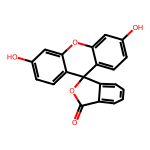

In [7]:
# @title Choose the molecule to draw { display-mode: "form" }
use_smiles = False # @param {type:"boolean"}
smile = 'COC1=CC2=C(C=CN=C2C=C1)[C@H]([C@@H]3C[C@@H]4CCN3C[C@@H]4C=C)O' # @param {type:"string"}
name = 'fluorescein' # @param {type:"string"}
if not use_smiles :
    smile=cirpy.resolve( name,'smiles')
img = Draw.MolToImage( Chem.MolFromSmiles(smile), size=(150, 150) )
display(img)

## Load and Visualize the First Experiment

We can read the files into a `Pandas.DataFrame` object using the `pd.read_csv()` function. Note that both the emission and absorption files have two columns and the label for the columns are in the second row. The first column contains the wavelenght in nanometers, the second column contains the emission/absorbance of the solution recorded by the spectrometers. However, at the end of the files there are several lines with information on the experiment. When `Pandas` reads these lines it gets confused on the type of data in the columns and on the number of columns. We could clean up the files before processing them or we can help `Pandas` clean up the data. 

In [8]:
# @title Load data from a file { display-mode: "form" }
file = '2 F.csv' # @param {type:"string"}
plot = True # @param {type:"boolean"}
# The header=1 option tells Pandas to find the column names in the second line of the file
# The usecols=(0,1) options tells Pandas to only collect the first two columns of data

# The data read so far contains strings and strange things at the end of the file
# We can clean it by forcing Pandas to convert the strings to numbers
# Actual strings will return an error, which Pandas will save as NaN
# adding the .dropna() function at the end get rids of these cells
data=data.apply(pd.to_numeric,errors='coerce').dropna()
data.info()
if plot :
  data.plot(x='Wavelength (nm)', y=data.columns[1], label=file)
  plt.xlabel('Wavelength (nm)',fontsize=14)
  plt.ylabel(data.columns[1],fontsize=14)
  plt.show()

NameError: name 'data' is not defined

## Normalize the Curve wrt the Highest Peak {-}

The units of the plotted spectrum are arbitrary (in this case a.u. means arbitrary units, not atomic units) and it is customable to compare the general shape of spectra by scaling them with respect to their peak of highest intensity. In order to do this, we need to figure out the intensity of the highest peak and divide the spectrum by it. How can we do it with Python?

Let's load a data file to work with

In [ ]:
file = 'Stock Q.csv'
data=pd.read_csv(path+file,header=1,usecols=(0,1))
data=data.apply(pd.to_numeric,errors='coerce').dropna()
data.info()

and create a new column of data with the scaled intensity defined as the spectrum intensity divided by the maximum value:

It may be useful to not only know the value of the maximum intenstiy, but also know the corresponding position of the peak on the horizontal axis, i.e., the value of the wavelength at which the molecule has the maximum fluorescence. In order to find this the process is slightly more convoluted:
1. we first find the index of the row at which the 'Intensity (a.u.)' is maximum using the `.idxmax()` method
2. we then look up the row that corresponds to that index and pick the value of the corresponding 'Wavelenght (nm)' 

In [ ]:
data['Intensity (a.u.)'].idxmax()

In [ ]:
data.loc[data['Intensity (a.u.)'].idxmax(),'Wavelength (nm)']

## Integral of a Curve using Numpy {-} 

In [ ]:
# @title Integrate the curve within an interval { display-mode: "form" }
lambda_min = 350 # @param {type:"integer"}
lambda_max = 632 # @param {type:"integer"}
file = 'Stock F.csv' # @param {type:"string"}
plot = True # @param {type:"boolean"}
emission_data=pd.read_csv(path+file,header=1,usecols=(0,1))
emission_data=emission_data.apply(pd.to_numeric,errors='coerce').dropna()
if 'Intensity (a.u.)' not in emission_data.columns:
    print('The file does not contain the expected column')
else:
    filterdata = emission_data.query(f'`Wavelength (nm)`>{lambda_min} and `Wavelength (nm)`<{lambda_max}')
    x = filterdata['Wavelength (nm)'].values
    y = filterdata['Intensity (a.u.)'].values
    area =  np.trapz(y,x)
if not plot :
    print(f'The integral of the spectrum between {lambda_min} nm and {lambda_max} nm is {area :.1f}')
else:
    ax = emission_data.plot(x='Wavelength (nm)', y=emission_data.columns[1], label=file,legend=False)
    plt.xlabel('Wavelength (nm)',fontsize=14)
    plt.ylabel('Intensity (a.u.)',fontsize=14)
    plt.legend()
    plt.text(0.9, 0.8, f'Area: {area:.2f}', fontsize=14, ha='right', va='top', transform=plt.gca().transAxes)
    plt.fill_between(x, y, 0, alpha=0.3, color='green', label='Area')  # Filled area 
    plt.show()

## Value of a Curve at a Specific Abscissa 

In [9]:
# @title Find the intensity of a spectrum at a specific wavelength { display-mode: "form" }
wavelength = 335 # @param {type:"integer"}
file = '2 F UV.csv' # @param {type:"string"}
plot = True # @param {type:"boolean"}
data=pd.read_csv(path+file,header=1,usecols=(0,1))
data=data.apply(pd.to_numeric,errors='coerce').dropna()
data['Relative Wavelength'] = np.abs(data['Wavelength (nm)'] - wavelength)
idx = data['Relative Wavelength'].idxmin()
data = data.drop(columns='Relative Wavelength')
intensity_value = data.iloc[idx,1]
if not plot:
    print(f'The intesity at {wavelength} nm is :{intensity_value :.8f}')
else:
    data.plot(x='Wavelength (nm)', y=data.columns[1], label=file,legend=False)
    plt.plot(wavelength,intensity_value,'ro')
    plt.axhline(y=intensity_value, color='r', linestyle=':')
    plt.axvline(x=wavelength, color='r', linestyle=':')
    plt.text(wavelength+10, intensity_value, f'{intensity_value:.6f}', color='red', ha='left', va='bottom',fontsize=12)
    plt.xlabel('Wavelength (nm)',fontsize=14)
    plt.ylabel('Intensity (a.u.)',fontsize=14)
    plt.legend()
    plt.show()

NameError: name 'path' is not defined